In [28]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from dataset import get_data

train_dl, valid_dl = get_data()

In [3]:
from dataclasses import dataclass
from torch.utils.data import Dataset, DataLoader

@dataclass
class Databunch:
    train_dl:DataLoader = train_dl
    valid_dl:DataLoader = valid_dl
    train_ds:Dataset    = train_dl.dataset
    valid_ds:Dataset    = valid_dl.dataset
    c_in:int             = train_dl.dataset[0][0].shape[0]
    c_out:int            = len(train_dl.dataset.classes)
        
data = Databunch()

In [4]:
data.c_in, data.c_out

(3, 5)

In [5]:
import torch

from functools import partial

from callback import AvgStatsCallback, CudaCallback, ProgressCallback, ParamScheduler, Recorder, LR_Find
from temp_model import get_learner, accuracy, conv_layer

In [6]:
cbfs = [partial(AvgStatsCallback, accuracy),
        partial(CudaCallback, torch.device('cuda')),
        ProgressCallback,
        Recorder, 
        LR_Find]

In [7]:
nfs = [32, 32, 64, 64]
learn = get_learner(nfs, data, 0.1, conv_layer, cb_funcs=cbfs)

In [8]:
learn.wrapper.freeze_features()

In [9]:
learn.wrapper.summary()




0: 0-Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
False
1: 1-BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
False
False
2: 2-ReLU(inplace=True)
3: 3-MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
4: 4-Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(

In [12]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


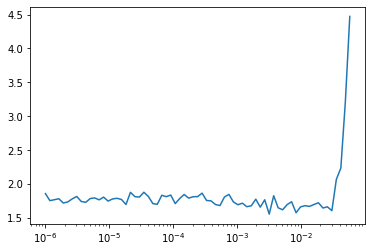

In [15]:
learn.recorder.plot(skip_last=7)

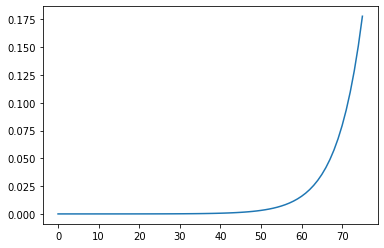

In [16]:
learn.recorder.plot_lr()

In [10]:
from callback import sched_cos, combine_scheds

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

lr = 0.01

phases = combine_scheds([0.3, 0.7], cos_1cycle_anneal(lr*5, lr, lr/10))

In [11]:
cbfs = [partial(AvgStatsCallback, accuracy),
        partial(CudaCallback, torch.device('cuda')),
        partial(ParamScheduler, 'lr', phases),
        ProgressCallback,
        Recorder]

In [12]:
learn = get_learner(nfs, data, 0.01, conv_layer, cb_funcs=cbfs)

In [13]:
learn.wrapper.freeze_features()
learn.wrapper.summary()




0: 0-Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
False
1: 1-BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
False
False
2: 2-ReLU(inplace=True)
3: 3-MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
4: 4-Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(

In [14]:
learn.data.train_ds[0][0].shape

torch.Size([3, 128, 128])

In [15]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.726097,0.328327,1.428663,0.347075,10:05


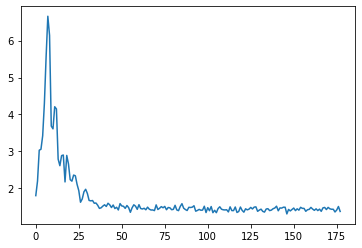

In [16]:
learn.recorder.plot_loss()

In [17]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.844815,0.342642,1.404427,0.368569,09:51
1,1.378771,0.380302,1.379369,0.378612,09:43


In [18]:
torch.save(learn.model.state_dict(), 'model.pt')

In [19]:
learn.model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [21]:
learn.wrapper.partial_freeze_features(0.7)
learn.wrapper.summary()




0: 0-Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
False
1: 1-BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
False
False
2: 2-ReLU(inplace=True)
3: 3-MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
4: 4-Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(

In [22]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.541301,0.386865,1.262432,0.441156,07:14
1,1.223151,0.457825,1.245651,0.445032,07:27


In [24]:
learn.wrapper.freeze_features(False)
learn.wrapper.summary()




0: 0-Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
True
1: 1-BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
True
True
2: 2-ReLU(inplace=True)
3: 3-MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
4: 4-Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 

In [25]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.262987,0.439986,1.205248,0.462121,08:01
1,1.130089,0.501652,1.179239,0.477097,08:08


In [26]:
torch.save(learn.model.state_dict(), 'model.pt')
learn.model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [33]:
train_dl, valid_dl = get_data()

@dataclass
class Databunch:
    train_dl:DataLoader = train_dl
    valid_dl:DataLoader = valid_dl
    train_ds:Dataset    = train_dl.dataset
    valid_ds:Dataset    = valid_dl.dataset
    c_in:int             = train_dl.dataset[0][0].shape[0]
    c_out:int            = len(train_dl.dataset.classes)
        
data = Databunch()

In [34]:
learn.data = data

In [37]:
learn.wrapper.freeze_features(True)
learn.wrapper.summary()




0: 0-Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
False
1: 1-BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
False
False
2: 2-ReLU(inplace=True)
3: 3-MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
4: 4-Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(

In [38]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.211153,0.480465,1.147403,0.493481,08:13


In [39]:
learn.wrapper.freeze_features(False)
learn.wrapper.summary()




0: 0-Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
True
1: 1-BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
True
True
2: 2-ReLU(inplace=True)
3: 3-MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
4: 4-Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 

In [40]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.166564,0.482227,1.116673,0.509514,08:50
1,1.057649,0.536141,1.094282,0.519732,08:56


In [41]:
learn.fit(4)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.144763,0.489098,1.105553,0.516209,08:35
1,1.004108,0.562349,1.120252,0.514094,08:45
2,0.973365,0.577721,1.076083,0.538760,09:00
3,0.947096,0.591287,1.073570,0.538055,09:03
